# Линейная регрессия.

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import autograd

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## Зарузка данных.

Стоимость недвижимости в Калифорнии.

In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [4]:
housing.data.shape, housing.target.shape

((20640, 8), (20640,))

In [5]:
type(housing.data), type(housing.target)

(numpy.ndarray, numpy.ndarray)

In [6]:
# Масштабируем данные.
from sklearn.preprocessing import StandardScaler 

In [7]:
scaler = StandardScaler()

In [8]:
data = scaler.fit_transform(housing.data)

In [9]:
target = (housing.target - housing.target.mean()) / housing.target.std()

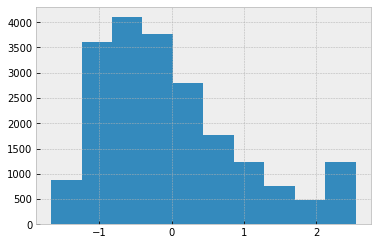

In [10]:
with plt.style.context('bmh'):
    plt.hist(target)

In [11]:
# Разобъем данные на обучающую и тестовую выборки.
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=73)

In [13]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
device

device(type='cuda')

In [16]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

## Линейная регрессия на PyTorch.

In [17]:
from torch.utils.data import TensorDataset, DataLoader

In [18]:
# Два набора данных: для обучения и тестирования.
batch_size = 16
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

In [19]:
# Randomly reading mini-batches
data_train = DataLoader(dataset_train, batch_size, shuffle=True)
data_test = DataLoader(dataset_test, batch_size)

In [20]:
# Read a batch to see how it works
for X, y in data_train:
    print(X, y)
    break

tensor([[-8.1898e-01,  6.6431e-01, -1.1940e-01, -1.0332e-01, -1.8233e-01,
         -7.1667e-02, -1.3492e+00,  1.2477e+00],
        [-1.0293e+00,  1.2205e+00, -1.0956e+00, -1.1685e-03,  5.3206e-01,
          3.3627e-02, -7.4061e-01,  6.3375e-01],
        [ 4.1170e-01, -1.3027e-01, -1.6573e-01, -2.6949e-01,  3.0688e-01,
         -1.3248e-03, -6.3292e-01,  4.2910e-01],
        [-1.3043e+00,  1.0810e-01, -5.5016e-01, -9.6027e-02,  1.3242e+00,
          1.7616e-02,  1.3522e+00, -9.2853e-01],
        [ 2.1358e+00, -1.2427e+00,  9.1912e-01, -2.2848e-01,  5.7604e-03,
          2.4250e-02, -9.5597e-01,  9.3822e-01],
        [ 1.7409e-01,  5.0539e-01,  1.4292e-01,  2.9535e-02,  1.4528e-01,
          6.8976e-03, -1.3212e+00,  1.3425e+00],
        [ 6.7331e-01,  5.0539e-01,  7.3850e-01, -8.9005e-02, -2.9978e-01,
         -1.0738e-02,  9.7296e-01, -1.2580e+00],
        [-6.5738e-01, -1.1632e+00, -3.0109e-01,  5.6719e-03,  6.7600e-01,
         -2.6919e-02,  3.1750e-01, -9.9974e-02],
        [ 1.2254

In [21]:
class LinearRegressionModel(torch.nn.Sequential):

    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(8, 1) # One in and one out

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

# our model
our_model = LinearRegressionModel()

# move to device.
our_model.to(device)

criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.RMSprop(our_model.parameters(), lr = 0.0001)

loss_per_epoch = np.zeros(100)

for epoch in tqdm(range(100)):
    for X, y in data_train:
        # X, y = X.to(device), y.to(device)
        pred_y = our_model(X)
        loss = criterion(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # считаем loss на тренировочных данных
    loss = criterion(our_model(X_train), y_train)
    loss_per_epoch[epoch] = loss
    # print('epoch {}, loss {}'.format(epoch, loss.item()))

  0%|                                                                                                                                   | 0/100 [00:00<?, ?it/s]/home/sergey/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/sergey/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([14448])) that is different to the input size (torch.Size([14448, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

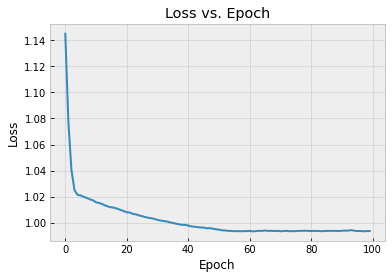

In [22]:
with plt.style.context("bmh"):
    plt.plot(loss_per_epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")

In [23]:
# MSE on test data.
error = (our_model(X_test) - y_test).pow(2).mean().item()
print('MSE on test data: {}'.format(error))

MSE on test data: 1.0225931406021118


In [24]:
prediction = our_model(X_test).detach().cpu().numpy()
y = y_test.detach().cpu().numpy()

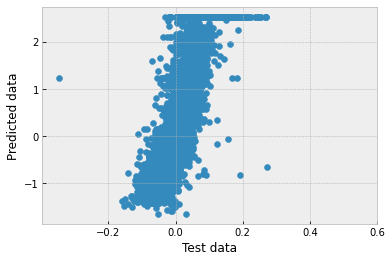

In [25]:
with plt.style.context('bmh'):
    plt.scatter(prediction, y)
    plt.xlim(right=0.6)
    plt.xlabel("Test data")
    plt.ylabel("Predicted data")